In [1]:
# 下面是 python 得内建库
# 导入functools库中的reduce函数，该函数将一个二元操作符应用于序列的项，将其规约到单个值  
from functools import reduce  
  
# 导入operator库，它提供了一系列内置的运算符函数  
import operator  
  
# 导入copy库，提供了浅拷贝和深拷贝对象的方法  
import copy  
  
# 导入time库，提供了与时间相关的各种函数  
import time

# 导入shutil库，提供了高级文件操作功能，如复制、删除目录和文件  
import shutil

# 基本的库，用于操作文件系统和系统路径
import os

# 导入PyTorch库，PyTorch是一个用于深度学习的开源库  
import torch  
  
# 导入PyTorch中的神经网络模块，提供了构建神经网络所需的各种层  
import torch.nn as nn  
  
# 导入PyTorch中的优化器模块，提供了各种优化算法如SGD, Adam等  
import torch.optim as optim  
  
# 导入PyTorch中的功能函数模块，提供了一系列激活函数、损失函数等  
import torch.nn.functional as F  
  
# 从PyTorch的utils模块中导入SummaryWriter，用于TensorBoard的日志记录  
from torch.utils.tensorboard import SummaryWriter  
  
# 从PyTorch的优化器模块中导入学习率调度器，如StepLR和ExponentialLR  
from torch.optim.lr_scheduler import StepLR, ExponentialLR  
  
# 从torchvision库中导入datasets和transforms模块  
# torchvision是PyTorch的一个扩展库，提供了计算机视觉相关的数据集、模型和图像转换工具  
from torchvision import datasets, transforms  
  
# 导入yaml库，用于读取和写入YAML格式的文件  
import yaml  
  
# 导入matplotlib的pyplot模块，用于绘制图表和可视化数据  
import matplotlib.pyplot as plt  
  
# 导入numpy库，一个强大的科学计算库，提供了多维数组对象、数学函数等  
import numpy as np  

%matplotlib inline

In [2]:
# 载入配置文件
with open('config/config_cnn.yaml', 'r') as f:
    config = yaml.safe_load(f)

# 配置参数
conv_layers = config['model']['conv_layers']
filter_size = config['model']['filter_size']
stride = config['model']['stride']
padding = config['model']['padding']
pool_type = config['model']['pool_type']
pool_size = config['model']['pool_size']
pool_stride = config['model']['pool_stride']
hidden_layers = config['model']['hidden_layers']
activation_function = config['model']['activation_function']
use_batch_norm = config['model']['use_batch_norm']
dropout_rate = config['model']['dropout_rate']
regularization = config['model']['regularization']
l1_lambda = config['model']['l1_lambda']
l2_lambda = config['model']['l2_lambda']
optimizer_type = config['optimizer']['type']
learning_rate = config['optimizer']['learning_rate']
lr_scheduler = config['optimizer']['lr_scheduler']
step_size = config['optimizer']['step_size']
gamma = config['optimizer']['gamma']
input_size = config['model']['input_size']
output_size = config['model']['output_size']
batch_size = config['batch_size']


# 加载器的线程数量，0表示不开启额外多余线程
num_workers = 0
# bs 大小
batch_size = 128

# 转换到 tensor 的 pipe
transform = transforms.ToTensor()

# 3. 导入数据，根据 train 参数是否为 True 分为训练集和测试集
train_data = datasets.EMNIST(root='./data',split='balanced', train=True,
                                   download=True, transform=transform)
test_data = datasets.EMNIST(root='./data',split='balanced', train=False,
                                  download=True, transform=transform)

# 4.a Print-out the number of training/testing samples in the dataset
print("the number of train data samples: ", len(train_data))
print("the number of test data samples: ", len(test_data))

# 创建训练集的数据加载器
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

the number of train data samples:  112800
the number of test data samples:  18800


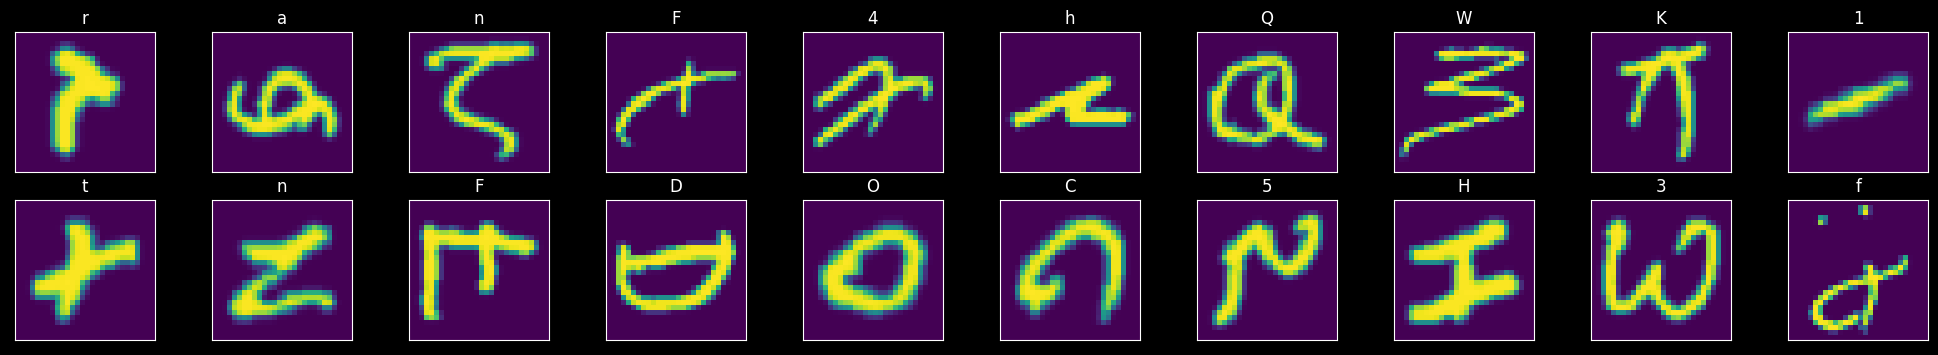

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)

images, labels = dataiter.__next__()
images = images.numpy()

 # emnist-balanced-mapping.txt 
with open('data/EMNIST/processed/emnist-balanced-mapping.txt') as f: 
    lines = f.readlines()
    
label_dict = {}
for row in lines:
    list1 = row.split(' ')
    label_dict[int(list1[0])] = chr(int(list1[1]))
    #索引值 (list1[0])  对应 ASCII code (list1[1])

# 4.b plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='viridis')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(label_dict.get(labels[idx].item())))

In [4]:
img = np.squeeze(images[0])
width, height = img.shape
print(width, height)


28 28


In [5]:
# define the activation function
if activation_function == 'ReLU':
    activation = nn.ReLU()
elif activation_function == 'LeakyReLU':
    activation = nn.LeakyReLU()
elif activation_function == 'ELU':
    activation = nn.ELU()


# define the model
layers = []
linear_input = copy.deepcopy(input_size)
print(linear_input)

for i in range(len(conv_layers)):
    if i == 0:
        layers.append(nn.Conv2d(input_size[0], conv_layers[i], filter_size[i], stride[i], padding[i]))
    else:
        layers.append(nn.Conv2d(conv_layers[i-1], conv_layers[i], filter_size[i], stride[i], padding[i]))
    layers.append(activation)
    if pool_type == 'MaxPool':
        layers.append(nn.MaxPool2d(pool_size[i], pool_stride[i]))
    elif pool_type == 'AvgPool':
        layers.append(nn.AvgPool2d(pool_size[i], pool_stride[i]))
    layers.append(nn.BatchNorm2d(conv_layers[i])) if use_batch_norm else nn.Identity(),
    layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),
    linear_input[0] = conv_layers[i]
    linear_input[1] = (linear_input[1] - filter_size[i] + 2*padding[i]) // stride[i] + 1
    linear_input[2] = (linear_input[2] - filter_size[i] + 2*padding[i]) // stride[i] + 1
    linear_input[1] = (linear_input[1] - pool_size[i] ) // pool_stride[i] + 1
    linear_input[2] = (linear_input[2] - pool_size[i] ) // pool_stride[i] + 1      
    
product = reduce(operator.mul, linear_input, 1)
layers.append(nn.Flatten(start_dim=1))
for i in range(len(hidden_layers)):
    if i == 0:
        layers.append(nn.Linear(product, hidden_layers[i]))
    else:
        layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
    layers.append(activation)
    layers.append(nn.BatchNorm1d(hidden_layers[i])) if use_batch_norm else nn.Identity(),
    layers.append(nn.Dropout(dropout_rate)) if dropout_rate else nn.Identity(),

layers.append(nn.Linear(hidden_layers[-1], output_size))
model = nn.Sequential(*layers)
print(model)

# 假设你的输入大小是 (batch_size, input_size)
# input_tensor = torch.randn((128,1,28,28))

# # 遍历模型的每一层
# for layer in model:
#     # 将输入张量传入当前层
#     output_tensor = layer(input_tensor)
#     # 打印当前层的输出形状
#     print(output_tensor.shape)
#     # 更新输入张量为当前层的输出，以便传入下一层
#     input_tensor = output_tensor
    
# class CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3)
#         self.conv2 = nn.Conv2d(16, 64, 3)
#         self.dense = nn.Linear(64, 47)
#         self.act = nn.ReLU()
#         self.pool = nn.AdaptiveAvgPool2d((1,1))
    
#     def forward(self, x):
#         # Layer 1
#         out = self.conv1(x)
#         out = self.act(out)

#         # Layer 2
#         out = self.conv2(out)
#         out = self.act(out)
#         # Pooling
#         out = self.pool(out).flatten(start_dim=-3)
#         # Klassifikation
#         out = self.dense(out)
#         return out
# model=CNN()


# define the optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_type == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
elif optimizer_type == 'ASGD':
    optimizer = optim.ASGD(model.parameters(), lr=learning_rate)
elif optimizer_type == 'AdaGrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)


# define the learning rate scheduler
if lr_scheduler == 'StepLR':
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
elif lr_scheduler == 'ExponentialLR':
    scheduler = ExponentialLR(optimizer, gamma=gamma)

# define the loss function
if regularization == 'L1':
    criterion = nn.CrossEntropyLoss() # or whatever loss function you are using
    def loss_function(output, target):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        return criterion(output, target) + l1_lambda * l1_norm
elif regularization == 'L2':
    criterion = nn.CrossEntropyLoss()  # or whatever loss function you are using
    def loss_function(output, target):
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        return criterion(output, target) + l2_lambda * l2_norm
else:
    loss_function = nn.CrossEntropyLoss()  # or whatever loss function you are using

[1, 28, 28]
Sequential(
  (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.1, inplace=False)
  (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.1, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=256, out_features=5

In [6]:
# number of epochs to train the model

log_time = time.time()
n_epochs = config['n_epochs']  # suggest training between 20-50 epochs
log_dir = f"hidden_layers_{'_'.join(map(str, hidden_layers))}_activation_{activation_function}_{log_time}"

# create the SummaryWriter
writer = SummaryWriter(f'runs/CNN/{log_dir}')
shutil.copy('config/config_mlp.yaml', f'runs/CNN/{log_dir}/config.yaml')

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running trainngi loss
        train_loss += loss.item()*data.size(0)
    scheduler.step()    
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    writer.add_scalar('Training Loss', train_loss, epoch)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    # close the SummaryWriter
    writer.close()

CUDA is available!  Training on GPU ...
Epoch: 1 	Training Loss: 4.687981
Epoch: 2 	Training Loss: 2.426407
Epoch: 3 	Training Loss: 1.855700
Epoch: 4 	Training Loss: 1.682323
Epoch: 5 	Training Loss: 1.585967
Epoch: 6 	Training Loss: 1.521445
Epoch: 7 	Training Loss: 1.471853
Epoch: 8 	Training Loss: 1.427310
Epoch: 9 	Training Loss: 1.389238
Epoch: 10 	Training Loss: 1.370680
Epoch: 11 	Training Loss: 1.317770
Epoch: 12 	Training Loss: 1.296798
Epoch: 13 	Training Loss: 1.281368
Epoch: 14 	Training Loss: 1.270082
Epoch: 15 	Training Loss: 1.261231
Epoch: 16 	Training Loss: 1.248561
Epoch: 17 	Training Loss: 1.244962
Epoch: 18 	Training Loss: 1.237624
Epoch: 19 	Training Loss: 1.230194
Epoch: 20 	Training Loss: 1.225863
Epoch: 21 	Training Loss: 1.197245
Epoch: 22 	Training Loss: 1.187538
Epoch: 23 	Training Loss: 1.182335
Epoch: 24 	Training Loss: 1.178424
Epoch: 25 	Training Loss: 1.173636
Epoch: 26 	Training Loss: 1.171315
Epoch: 27 	Training Loss: 1.167215
Epoch: 28 	Training Loss

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(47))
class_total = list(0. for i in range(47))

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    # calculate test accuracy for each object class
    for i in range(len(target.data)):  # change here
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(47):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), accuracy,
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    overall_accuracy,
    np.sum(class_correct), np.sum(class_total)))



Test Loss: 0.421197

Test Accuracy of     0: 57% (230/400)
Test Accuracy of     1: 79% (316/400)
Test Accuracy of     2: 83% (334/400)
Test Accuracy of     3: 96% (384/400)
Test Accuracy of     4: 93% (374/400)
Test Accuracy of     5: 93% (374/400)
Test Accuracy of     6: 86% (344/400)
Test Accuracy of     7: 96% (384/400)
Test Accuracy of     8: 94% (379/400)
Test Accuracy of     9: 82% (328/400)
Test Accuracy of    10: 96% (386/400)
Test Accuracy of    11: 94% (378/400)
Test Accuracy of    12: 94% (376/400)
Test Accuracy of    13: 81% (325/400)
Test Accuracy of    14: 97% (388/400)
Test Accuracy of    15: 49% (196/400)
Test Accuracy of    16: 89% (359/400)
Test Accuracy of    17: 96% (384/400)
Test Accuracy of    18: 63% (254/400)
Test Accuracy of    19: 90% (363/400)
Test Accuracy of    20: 95% (382/400)
Test Accuracy of    21: 24% (98/400)
Test Accuracy of    22: 93% (372/400)
Test Accuracy of    23: 94% (379/400)
Test Accuracy of    24: 76% (307/400)
Test Accuracy of    25: 98% (3

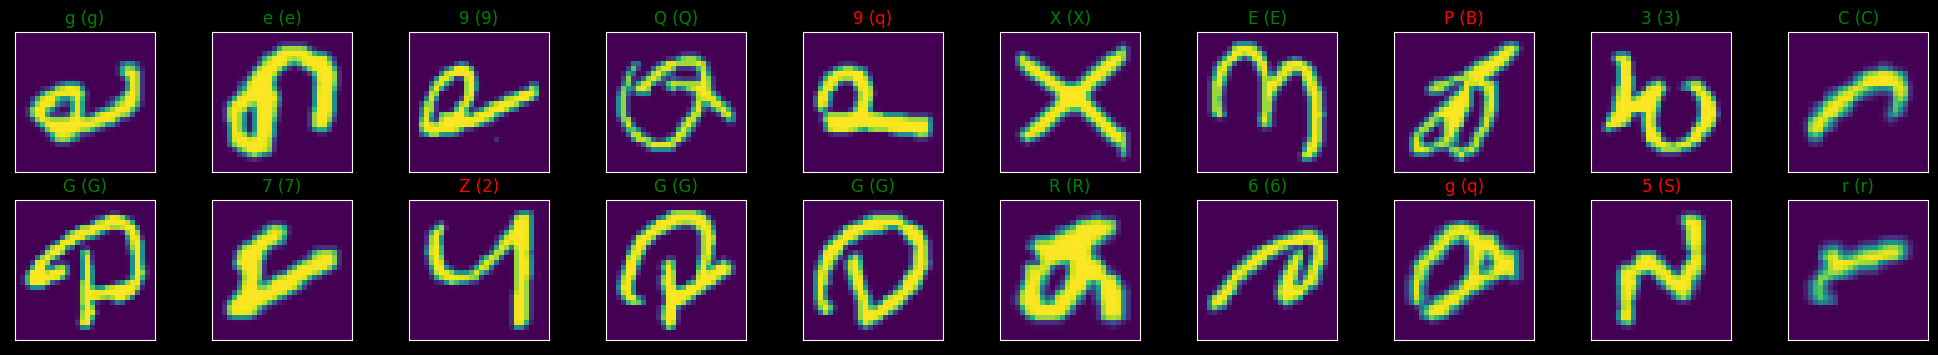

In [12]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# move model to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# move images and labels to GPU if CUDA is available
if train_on_gpu:
    images, labels = images.cuda(), labels.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# move images and preds back to CPU for displaying images and numpy operations
if train_on_gpu:
    images, preds = images.cpu(), preds.cpu()

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='viridis')
    ax.set_title("{} ({})".format(str(label_dict.get(preds[idx].item())), str(label_dict.get(labels[idx].item()))),
                 color=("green" if preds[idx]==labels[idx] else "red"))